In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset CORRECTLY
# We use 'header=0' to tell pandas the first valid line is the header
# We skip row 0 (the "Experiment Started" line)
df = pd.read_csv("results.txt", skiprows=1) 

# OPTIONAL: If column names have spaces like " Importance_Score", strip them
df.columns = df.columns.str.strip()

# 2. Force conversion to numeric (Crucial Safety Step)
# This turns " 0.0 " into 0.0 and turns any text errors into NaN
df["Importance_Score"] = pd.to_numeric(df["Importance_Score"], errors='coerce')

# 3. Clean whitespace from text columns
df["Feature_Perturbed"] = df["Feature_Perturbed"].astype(str).str.strip()

# 4. Now run the sanity check
total_non_zero = df[df["Importance_Score"] > 0].shape[0]
print(f"Total Rows Loaded: {len(df)}")
print(f"Rows with Non-Zero Importance: {total_non_zero}")

if total_non_zero == 0:
    print("⚠️ WARNING: All importance scores are 0.0. (This might be correct for trivial features like Street Type)")
else:
    print("✅ Success: The LLM reacted to changes!")

df.head()

Total Rows Loaded: 1562
Rows with Non-Zero Importance: 436
✅ Success: The LLM reacted to changes!


,Parcel_ID,Feature_Perturbed,Original_Price,New_Price,Importance_Score
0,531475220,Neighborhood,245000.0,245000.0,0.0
1,531475220,Overall Quality,245000.0,235000.0,10000.0
2,531475220,Overall Condition,245000.0,245000.0,0.0
3,531475220,Year Built,245000.0,245000.0,0.0
4,531475220,Year Remodeled/Added,245000.0,245000.0,0.0


In [2]:
# Group by Feature to get the Average Importance across all houses
feature_stats = df.groupby("Feature_Perturbed")["Importance_Score"].agg(["mean", "std", "max", "count"])

# Sort by the most important features
feature_stats = feature_stats.sort_values(by="mean", ascending=False)

# Rename columns for the report
feature_stats = feature_stats.rename(columns={"mean": "Avg_Impact_($)", "std": "Variability", "max": "Max_Single_Impact"})

# Show the Top 10 Features (This is your "Answer Key")
print("Top 10 Most Influential Features:")
display(feature_stats.head(10))

Top 10 Most Influential Features:


,Avg_Impact_($),Variability,Max_Single_Impact,count
Feature_Perturbed,,,,
Overall Quality,24507.042254,14974.142703,60000.0,71
Neighborhood,6239.436620,9184.559697,30000.0,71
First Floor Area (sqft),5457.746479,8472.116652,40000.0,71
Year Built,5194.366197,7784.744923,30000.0,71
Year Remodeled/Added,4957.746479,7706.095212,30000.0,71
Total Basement Area (sqft),4560.563380,7762.666679,30000.0,71
Above Ground Living Area (sqft),4176.056338,7612.066826,30000.0,71
Basement Finished Area 1 (sqft),4126.760563,8535.521705,40000.0,71
Exterior Quality,4084.507042,7285.497294,30000.0,71


/var/folders/m9/b36wl4j96vxgr9wbxq2zh6lm0000gn/T/ipykernel_37536/1963138731.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


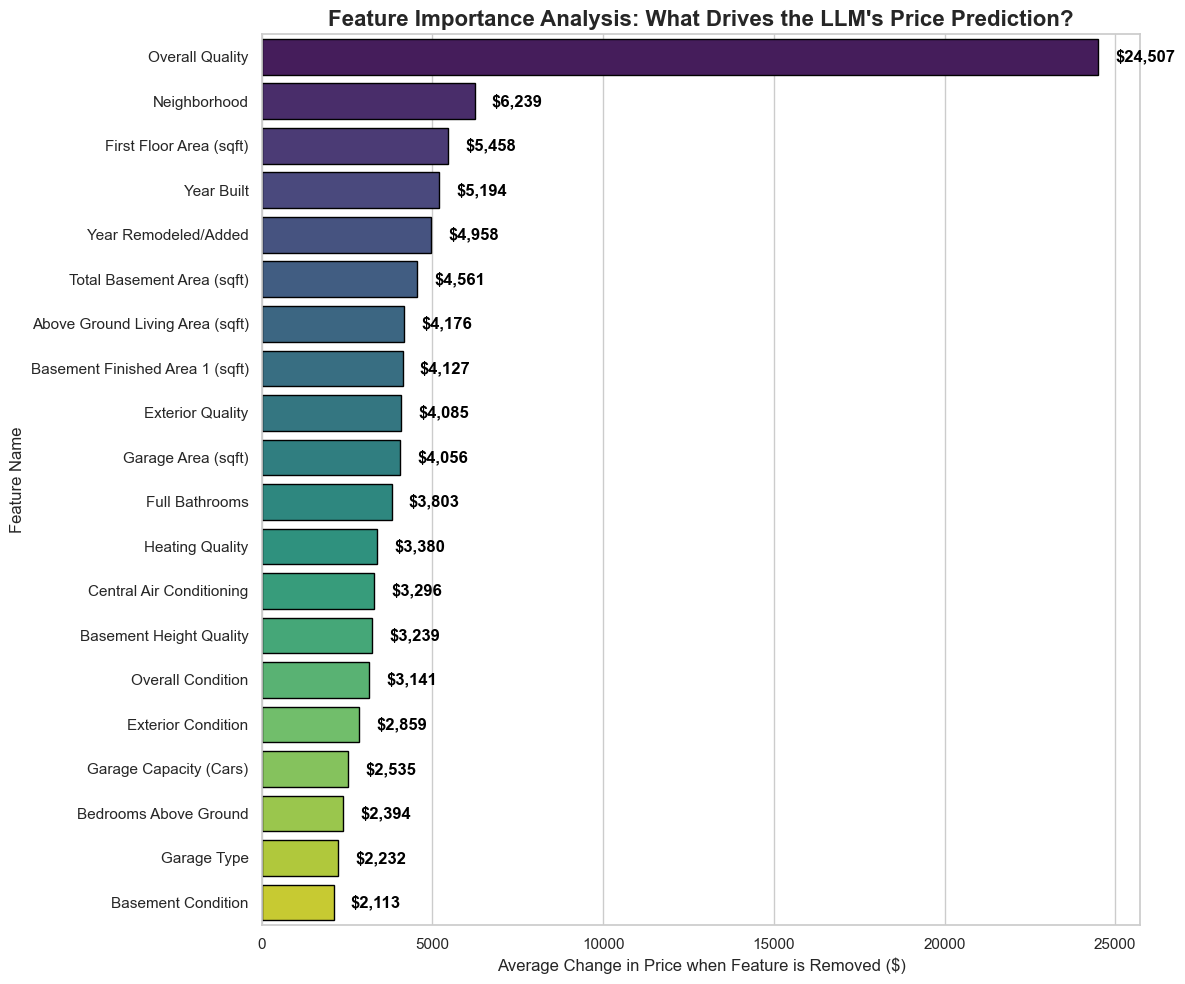

In [3]:
# Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 10))

# Select only the top 20 features to keep the graph readable
top_20_features = feature_stats.head(20)

# Create the Bar Chart
barplot = sns.barplot(
    x=top_20_features["Avg_Impact_($)"], 
    y=top_20_features.index, 
    palette="viridis",
    edgecolor="black"
)

# Add Labels & Titles for the Report
plt.title("Feature Importance Analysis: What Drives the LLM's Price Prediction?", fontsize=16, fontweight='bold')
plt.xlabel("Average Change in Price when Feature is Removed ($)", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)

# Add value labels to the end of bars
for i, v in enumerate(top_20_features["Avg_Impact_($)"]):
    barplot.text(v + 500, i, f"${v:,.0f}", color='black', va='center', fontweight='bold')

plt.tight_layout()

# Save the graph
plt.savefig("Final_Feature_Importance.png", dpi=300)
plt.show()

Generating Graph for: High Impact Features (22 features)...


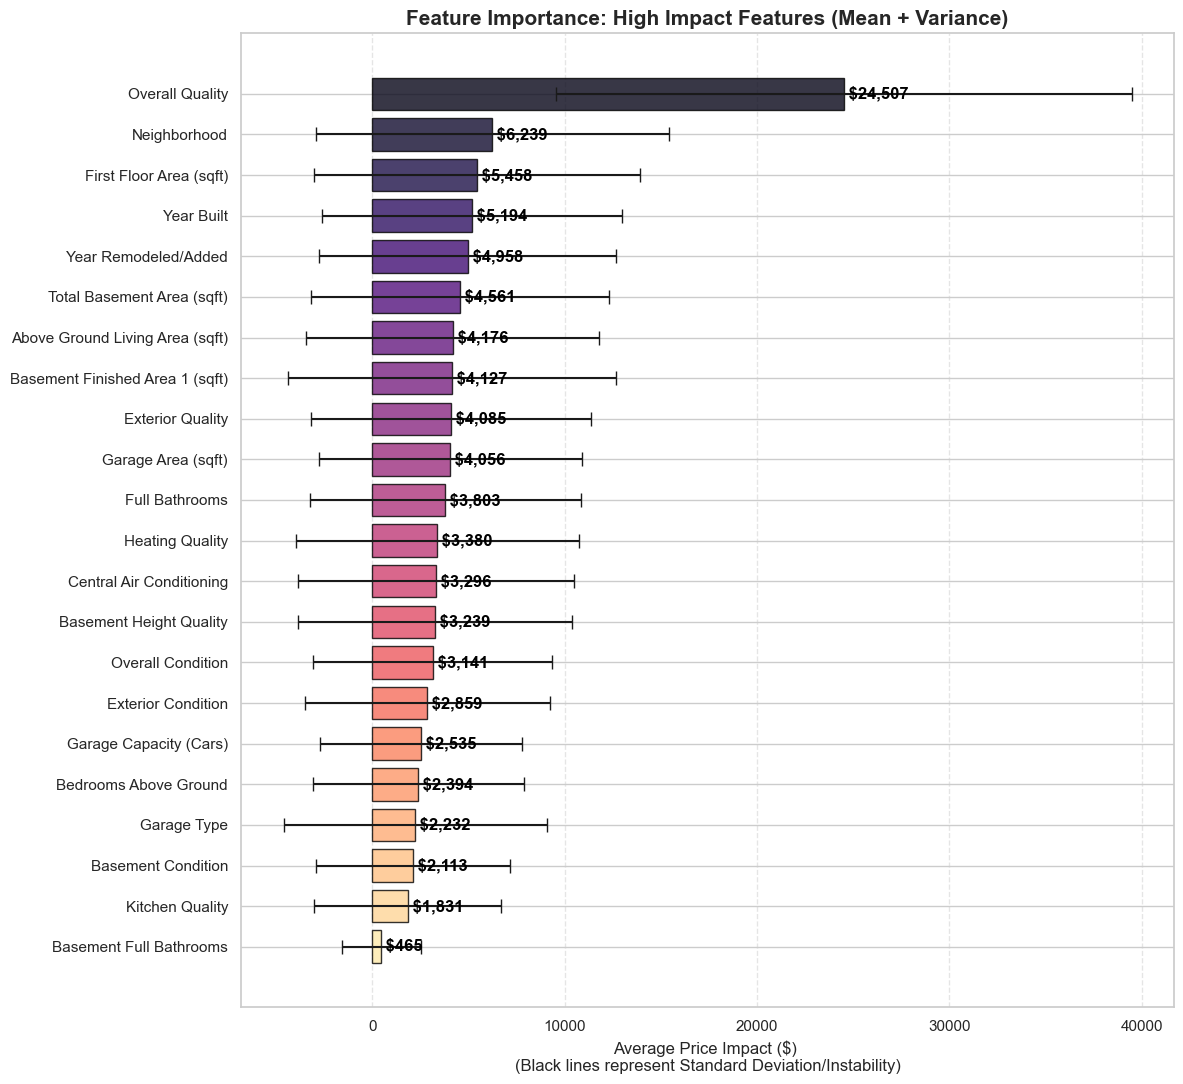

✅ All graphs generated with Mean and Variance!


In [4]:
# Cell: Generate Detailed Mean & Variance Plots for ALL Features

import matplotlib.pyplot as plt
import seaborn as sns
import math

# 1. Prepare Data
# We use the 'feature_stats' you already calculated
# Ensure it's sorted by impact
feature_stats = feature_stats.sort_values(by="Avg_Impact_($)", ascending=False)

# 2. Define a helper function to plot batches
def plot_feature_batch(stats_df, batch_name, color_palette="magma"):
    # Dynamic Height: 0.5 inches per feature to ensure readability
    fig_height = max(6, len(stats_df) * 0.5)
    
    plt.figure(figsize=(12, fig_height))
    
    # Create Horizontal Bar Plot
    # x = Mean Impact
    # xerr = Variability (Standard Deviation) -> This creates the black error bars
    plt.barh(
        y=stats_df.index, 
        width=stats_df["Avg_Impact_($)"], 
        xerr=stats_df["Variability"],  # <--- THIS ADDS THE VARIANCE
        color=sns.color_palette(color_palette, len(stats_df)),
        edgecolor="black",
        capsize=5, # Adds little caps to the error bars
        alpha=0.8
    )
    
    # Styling
    plt.title(f"Feature Importance: {batch_name} (Mean + Variance)", fontsize=15, fontweight='bold')
    plt.xlabel("Average Price Impact ($) \n(Black lines represent Standard Deviation/Instability)", fontsize=12)
    plt.gca().invert_yaxis() # Put the biggest impact at the top
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    
    # Add Text Labels
    for index, value in enumerate(stats_df["Avg_Impact_($)"]):
        # Label the Mean
        plt.text(value, index, f" ${value:,.0f}", va='center', fontweight='bold', color='black')
        
    plt.tight_layout()
    plt.savefig(f"Feature_Importance_{batch_name.replace(' ', '_')}.png", dpi=300)
    plt.show()

# 3. Logic to Split Features into Readable Batches
total_features = len(feature_stats)
batch_size = 25 # How many features per graph?

# Split dataframe into chunks
chunks = [feature_stats.iloc[i:i+batch_size] for i in range(0, total_features, batch_size)]

# 4. Generate the Graphs
labels = ["High Impact Features", "Medium Impact Features", "Low Impact Features", "Negligible Features"]

for i, chunk in enumerate(chunks):
    if i < len(labels):
        name = labels[i]
    else:
        name = f"Batch {i+1}"
        
    print(f"Generating Graph for: {name} ({len(chunk)} features)...")
    plot_feature_batch(chunk, name)

print("✅ All graphs generated with Mean and Variance!")